In [1]:
# !pip install "tensorflow<2.9"

In [2]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Constants and parameters

In [4]:
from IPython.core.getipython import get_ipython

DATASET_PATH = "datasets/PlantVillage"
SAVED_MODELS_PATH = "saved_models/potato_disease_classification/"

if "google.colab" in str(get_ipython()):
    DATASET_PATH = "drive/MyDrive/MyProjects/DeepLearning/" + DATASET_PATH
    SAVED_MODELS_PATH = "drive/MyDrive/MyProjects/DeepLearning/" + SAVED_MODELS_PATH

BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
SEED = None
EPOCHS = 50

Packages

In [3]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers, losses, models

Loading Dataset

In [5]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
)
type(dataset)

Found 2152 files belonging to 3 classes.


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [6]:
# number of batches in the dataset. 1 batch = 32 images (max)
len(dataset)

68

In [7]:
class_names = dataset.class_names
class_names

['Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy']

Visualization of loaded data

(32, 256, 256, 3)
(32,)


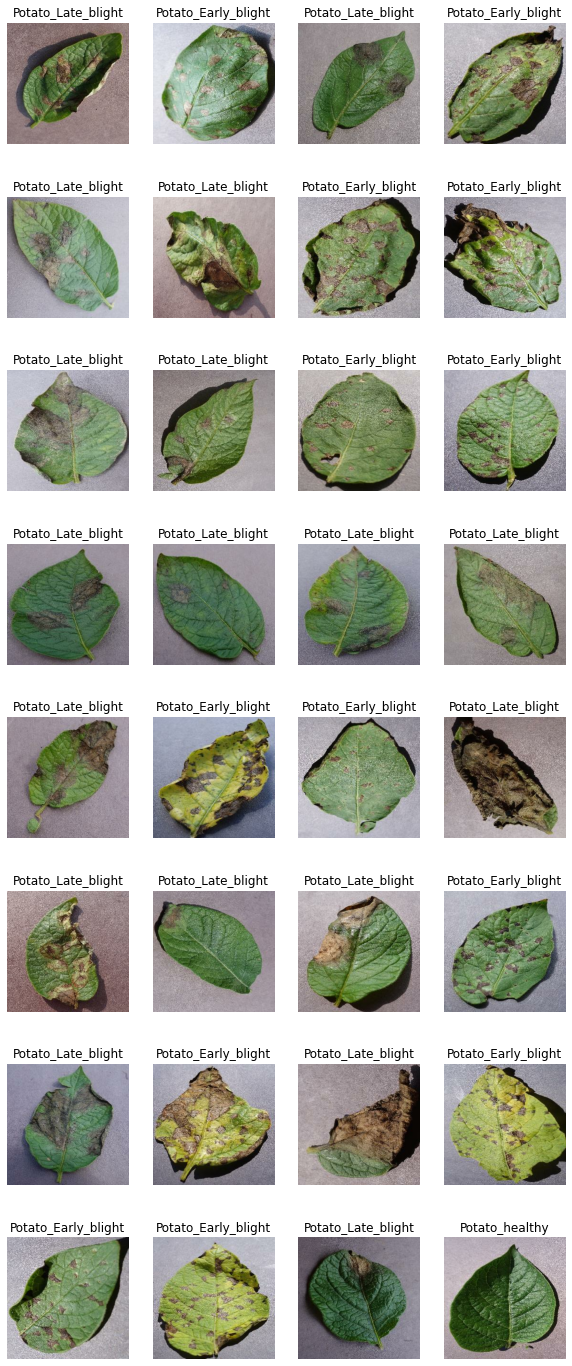

In [8]:
plt.figure(figsize=(10, 25))

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

    for i, (image, label) in enumerate(zip(image_batch, labels_batch)):
        plt.subplot(8, 4, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[label])
        plt.axis("off")

Function: splitting data

In [9]:
from typing import Any


def train_test_split(
    dataset: Any,
    train_ratio: float = 0.8,
    test_ratio: float = None,
    needs_validation: bool = False,
    validation_ratio: float = 0.5,
    shuffle_size: int = 100,
) -> tuple:
    """
    Splits the dataset into train, validation and test sets.
    If test_ratio is not specified, the remaining data is used for testing.
    If validation_ratio is not specified, the remaining data is used for validation.

    Parameters
    ----------
    dataset : Any
        The dataset to be split.
    train_ratio : float, optional
        The ratio of the dataset to be used for training, by default 0.8
    test_ratio : float, optional
        The ratio of the dataset to be used for testing, by default None
    needs_validation : bool, optional
        Whether the dataset has a validation set, by default False
    validation_ratio : float, optional
        The ratio of the dataset to be used for validation, by default 0.5
    shuffle_size : int, optional
        The size of the shuffle buffer, by default None

    Returns
    -------
    tuple
        The train, validation and test sets.

    Raises
    ------
    ValueError
        train_ratio and test_ratio cannot be both 0
    ValueError
        validation_ratio must be specified if needs_validation is True
    """

    if shuffle_size:
        dataset = dataset.shuffle(shuffle_size)

    if test_ratio:
        test = dataset.take(round(len(dataset) * test_ratio))
        train = dataset.skip(round(len(dataset) * test_ratio))
    elif train_ratio:
        train = dataset.take(round(len(dataset) * train_ratio))
        test = dataset.skip(round(len(dataset) * train_ratio))
    else:
        raise ValueError("train_ratio and test_ratio cannot be both 0")

    if needs_validation and validation_ratio:
        validation = test.take(round(len(test) * validation_ratio))
        test = test.skip(round(len(test) * validation_ratio))
        return train, validation, test
    elif needs_validation and not validation_ratio:
        raise ValueError(
            "validation_ratio must be specified if needs_validation is True"
        )

    return train, test

Splitting data

In [10]:
train, validation, test = train_test_split(
    dataset,
    needs_validation=True,
    shuffle_size=1000,
)
len(train), len(validation), len(test)

(54, 7, 7)

In [11]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Pre-processing layers

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(*IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

Model

In [13]:
input_shape = (BATCH_SIZE, *IMAGE_SIZE, 3)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

Model: Compile and Train

In [14]:
model.compile(
    optimizer="adam",
    # loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [15]:
history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation,
)

Epoch 1/50
54/54 [==============================] - 116s 156ms/step - loss: 0.9108 - accuracy: 0.5176 - val_loss: 0.8750 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - 4s 71ms/step - loss: 0.7137 - accuracy: 0.6761 - val_loss: 0.5045 - val_accuracy: 0.8300
Epoch 3/50
54/54 [==============================] - 4s 68ms/step - loss: 0.5086 - accuracy: 0.7964 - val_loss: 0.6635 - val_accuracy: 0.6500
Epoch 4/50
54/54 [==============================] - 4s 67ms/step - loss: 0.3964 - accuracy: 0.8392 - val_loss: 0.2545 - val_accuracy: 0.9200
Epoch 5/50
54/54 [==============================] - 4s 69ms/step - loss: 0.2494 - accuracy: 0.9055 - val_loss: 0.2871 - val_accuracy: 0.8850
Epoch 6/50
54/54 [==============================] - 4s 68ms/step - loss: 0.2234 - accuracy: 0.9196 - val_loss: 0.1618 - val_accuracy: 0.9600
Epoch 7/50
54/54 [==============================] - 4s 68ms/step - loss: 0.2371 - accuracy: 0.9126 - val_loss: 0.4211 - val_accuracy: 0.8100
Epoch 8/50

In [16]:
scores = model.evaluate(test, verbose=1)
scores

7/7 [==============================] - 4s 33ms/step - loss: 0.0657 - accuracy: 0.9777


[0.06574289500713348, 0.9776785969734192]

Model: Accuracy

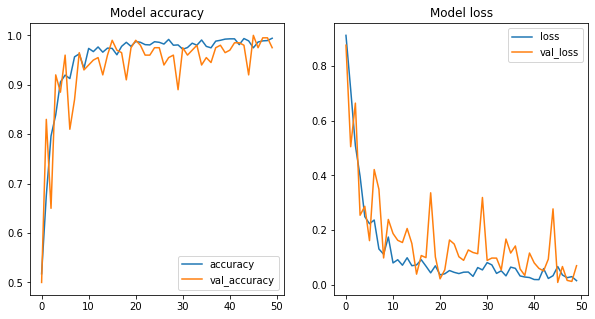

In [17]:
history.history.keys()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Model accuracy")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Model loss")
plt.legend(loc="best")

Function: prediction

In [20]:
def predict(image, model) -> "tuple[str, float]":
    img = tf.keras.preprocessing.image.img_to_array(image)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.expand_dims(img, axis=0)  # Creates a batch

    predictions = model.predict(img)

    class_name = class_names[np.argmax(predictions)]
    accuracy = round(np.max(predictions) * 100, 4)

    return class_name, accuracy

Prediction

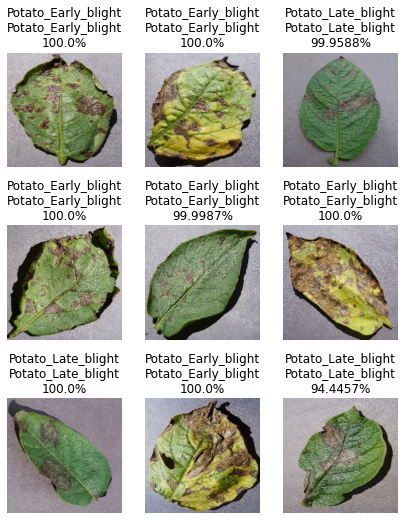

In [21]:
plt.figure(figsize=(7, 9))

for images, labels in test.take(1):
    for i, image, label in zip(range(9), images, labels):
        predicted_class_name, accuracy = predict(image, model)
        actual_class_name = class_names[label]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"{actual_class_name}\n{predicted_class_name}\n{accuracy}%")
        plt.axis("off")

Saving models

In [22]:
model_version = "v1.0"
model.save(f"{SAVED_MODELS_PATH}{model_version}")